In [1]:
import os
import json
import pickle

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

from tqdm import tqdm
from math import sqrt
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [2]:
network_analytics = pd.read_csv('./data/Network_Analytics.csv')
series = pd.Series(network_analytics['OutboundUtilzation (%)'])
network_analytics['Timestamp']=pd.to_datetime(network_analytics['Timestamp'])
network_analytics = network_analytics.set_index('Timestamp')

## Stationarity test

In [3]:
statistics, pval, usedlag, nobs, _, _ = adfuller(network_analytics['OutboundUtilzation (%)'], autolag='AIC')
if pval < 0.05:
    print(f"Data is stationary {statistics} {pval} {usedlag} {nobs}.")
else:
    print(f"Data is not stationary {statistics} {pval} {usedlag} {nobs}")

Data is stationary -12.704162687630873 1.0639878489319919e-23 49 25581.


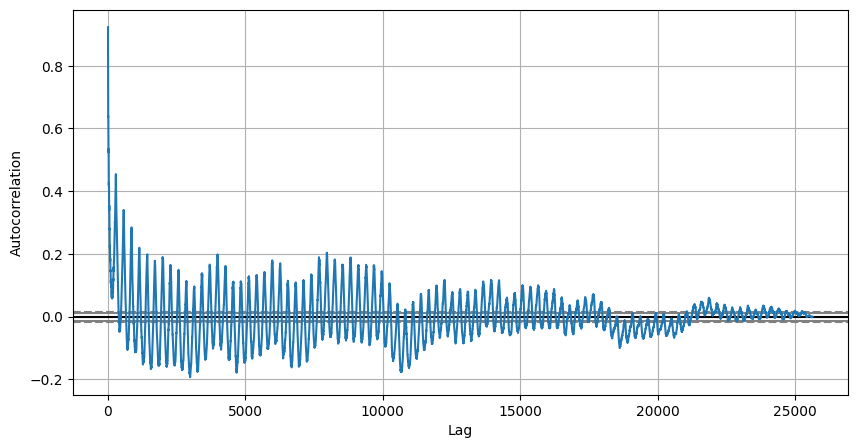

In [4]:
from pandas.plotting import autocorrelation_plot
fig, ax = plt.subplots(figsize=(10, 5))
autocorrelation_plot(series.values, ax)
plt.show()

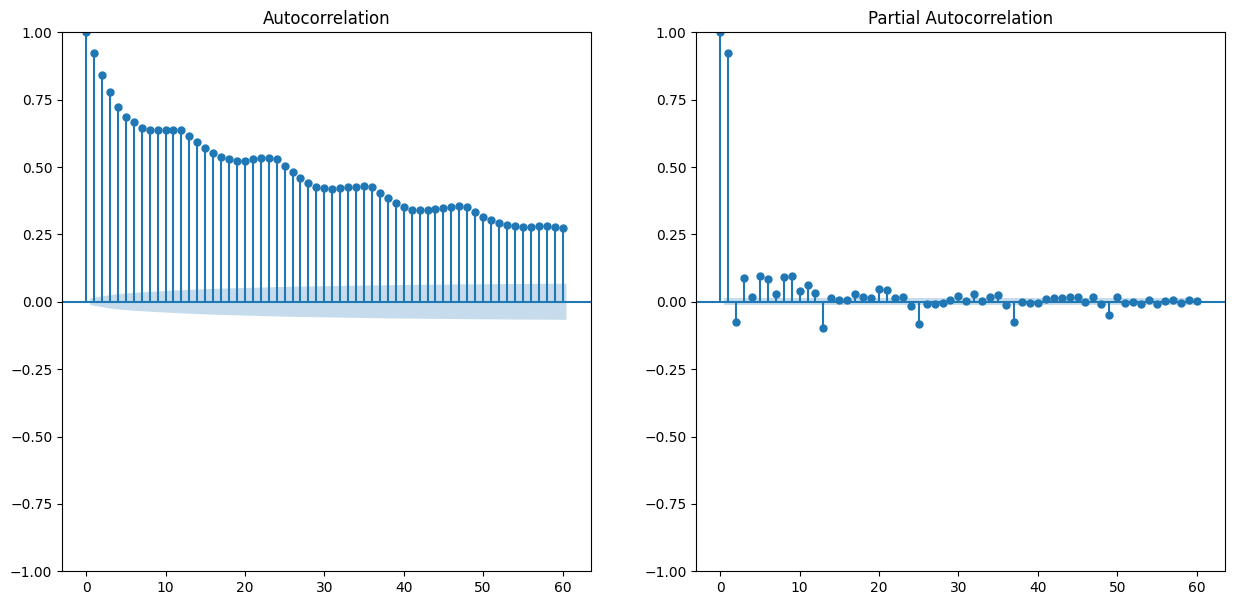

In [5]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
sm.graphics.tsa.plot_acf(series, lags=60, ax=ax[0])
sm.graphics.tsa.plot_pacf(series, lags=60, ax=ax[1])
plt.show()

In [6]:
network_analytics_2H = network_analytics.resample('2H').mean()
series = pd.Series(network_analytics_2H['OutboundUtilzation (%)'].values)

X = series.values
size = int(len(X) * 0.80)
train, test = X[0:size], X[size:len(X)]
print(len(train))
print(len(test))

867
217


In [7]:
def absolute_error_statistics(original : np.array, predicted : np.array):
    assert len(original) == len(predicted)
    return np.absolute(original - predicted)

In [8]:
model_fit = ARIMAResults.load('ARIMA3.pkl')

In [9]:
#TODO: save params of the MA and AR and provide them in .fit(params  = <burn_in_model>.params)
# model = ARIMA(285, 1, 49)
# future_cov = datetime_attribute_timeseries(series, "month", cyclic=True, add_length=6)
model = ARIMA(train, order=(285, 0, 49))
model_fit = model.fit(start_params=model_fit.params)
# model.fit(TimeSeries.from_series(pd.Series(train)))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
model_fit.save('ARIMA4.pkl')

In [11]:
def symmetric_mean_absolute_percentage_error(A, F):
    return 100/len(A) * np.sum(np.abs(F - A) / ((np.abs(A) + np.abs(F)) / 2))

RMSE: 29.347669243076172
MAPE: 0.605713931460443
SMAPE: 51.396479752365686
MAE: 23.99924857378247


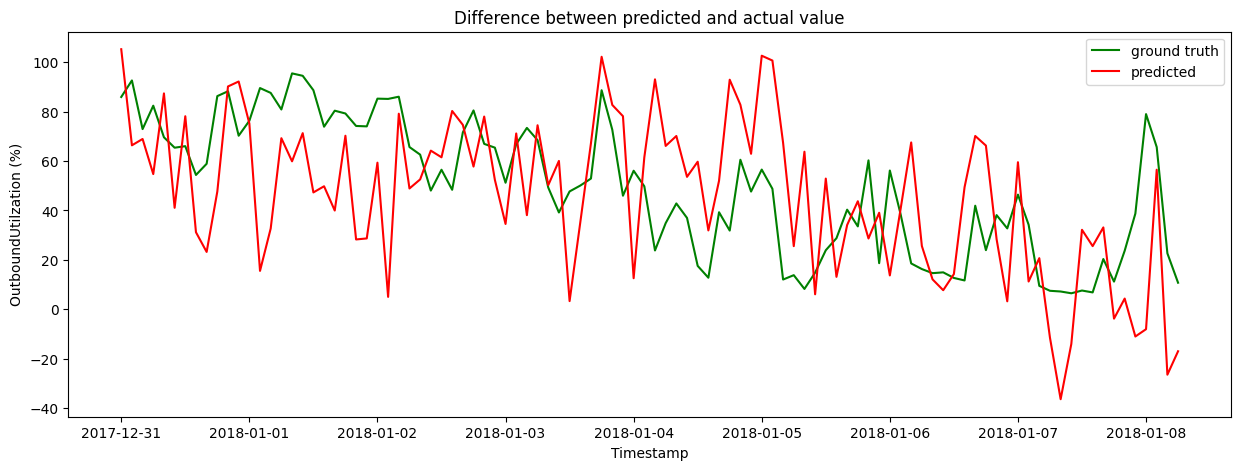

In [12]:
rmses = []
results = {}

coef = model_fit.params
history = train[len(train)-285:].tolist()

history_ma = train[len(train)-usedlag:].tolist()
pred = model_fit.predict(start=len(train) - usedlag + 1, end=len(train))
# Compute error between actual and prediction
errors = np.array(history_ma - pred).tolist()

predictions = list()
for t in range(len(test)):
    length = len(history)
    yhat = coef[0]
    for d in range(285):
        yhat += coef[d+1] * history[d]

    for d in range(usedlag):
        yhat += coef[d+285+1] * errors[usedlag-d-1]

    errors.pop(0)
    errors.append(test[t] - yhat)
    predictions.append(yhat)
    history.pop(0)
    history.append(test[t])

rmse = sqrt(mean_squared_error(test, predictions))
print(f"RMSE: {rmse}")

mape = mean_absolute_percentage_error(test, predictions)
print(f"MAPE: {mape}")

smape = symmetric_mean_absolute_percentage_error(test, predictions)
print(f"SMAPE: {smape}")

mae = mean_absolute_error(test, predictions)
print(f"MAE: {mae}")

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(network_analytics_2H.index[-100:], test[len(test)- 100:], color='g', label='ground truth')
ax.plot(network_analytics_2H.index[-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
plt.title('Difference between predicted and actual value')
plt.xticks(network_analytics_2H.index[-100::12])
plt.legend(loc='best')
plt.ylabel('OutboundUtilzation (%)')
plt.xlabel('Timestamp')
plt.show()

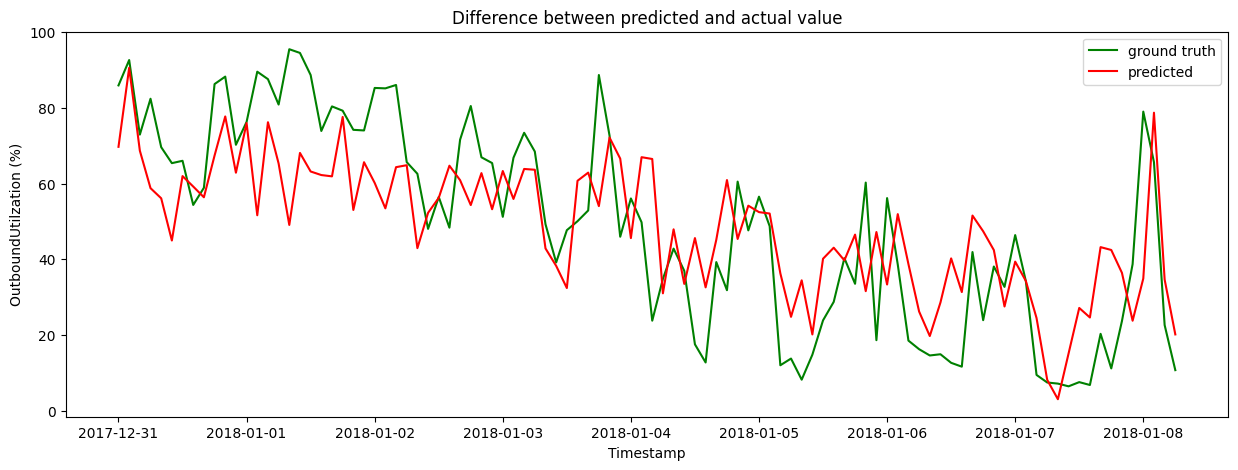

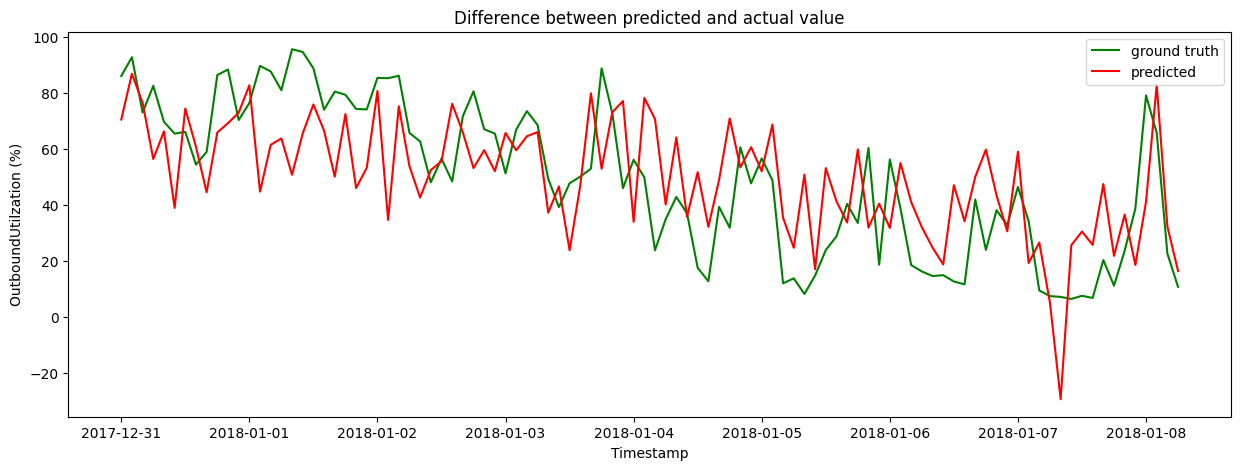

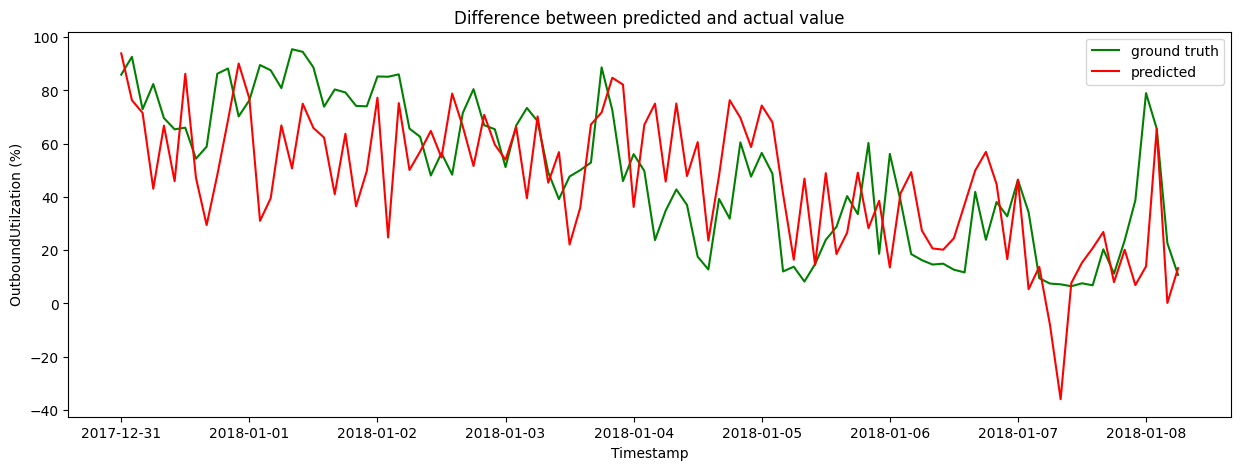

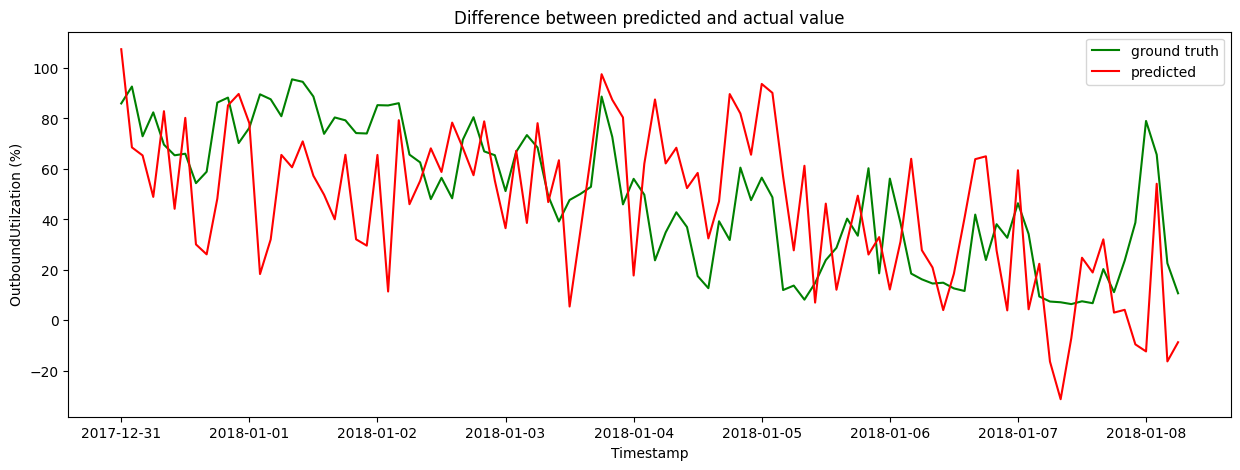

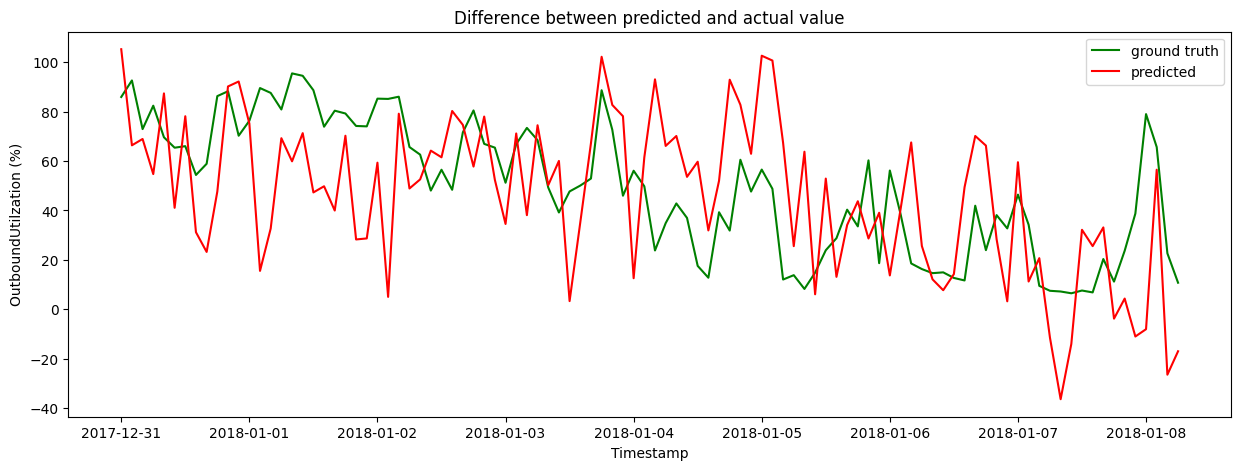

In [13]:
results = {
    'rmse' : [],
    'mape' : [],
    'smape' : [],
    'mae' : []
}

for model in ['ARIMA.pkl', 'ARIMA1.pkl', 'ARIMA2.pkl', 'ARIMA3.pkl', 'ARIMA4.pkl']:


    model_fit = ARIMAResults.load(model)

    coef = model_fit.params
    history = train[len(train)-285:].tolist()

    history_ma = train[len(train)-usedlag:].tolist()
    pred = model_fit.predict(start=len(train) - usedlag + 1, end=len(train))
    # Compute error between actual and prediction
    errors = np.array(history_ma - pred).tolist()

    predictions = list()
    for t in range(len(test)):
        length = len(history)
        yhat = coef[0]
        for d in range(285):
            yhat += coef[d+1] * history[d]

        for d in range(usedlag):
            yhat += coef[d+285+1] * errors[usedlag-d-1]

        errors.pop(0)
        errors.append(test[t] - yhat)
        predictions.append(yhat)
        history.pop(0)
        history.append(test[t])

    rmse = sqrt(mean_squared_error(test, predictions))
    results['rmse'].append(rmse)

    mape = mean_absolute_percentage_error(test, predictions)
    results['mape'].append(mape)

    smape = symmetric_mean_absolute_percentage_error(test, predictions)
    results['smape'].append(smape)

    mae = mean_absolute_error(test, predictions)
    results['mae'].append(mae)

    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(network_analytics_2H.index[-100:], test[len(test)- 100:], color='g', label='ground truth')
    ax.plot(network_analytics_2H.index[-100:], predictions[len(predictions) - 100:], color='r', label='predicted')
    plt.title('Difference between predicted and actual value')
    plt.xticks(network_analytics_2H.index[-100::12])
    plt.legend(loc='best')
    plt.ylabel('OutboundUtilzation (%)')
    plt.xlabel('Timestamp')
    plt.show()

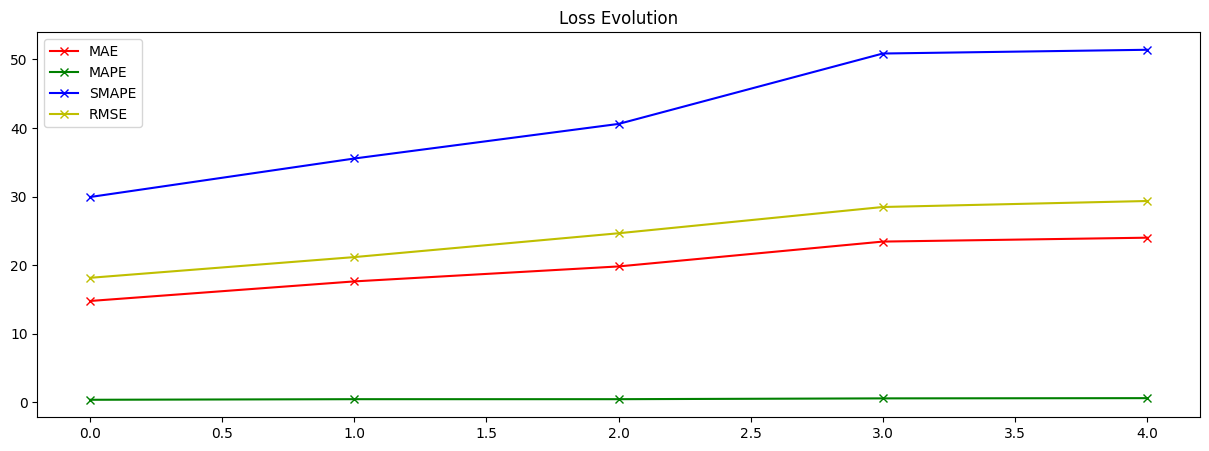

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(results['mae'], color='r', label='MAE', marker='x')
ax.plot(results['mape'], color='g', label='MAPE', marker='x')
ax.plot(results['smape'], color='b', label='SMAPE', marker='x')
ax.plot(results['rmse'], color='y', label='RMSE', marker='x')
plt.title('Loss Evolution')
plt.legend(loc='best')
plt.show()